In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(".")

In [2]:
#Model
from unet import UNet
model = UNet(in_channels=1, depth=2, act='relu', wf=6, 
                 padding=True, batch_norm=False, up_mode='upsample', 
                 twohead=True)

/Users/saeedizadi/Devs/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Loss
from collections import OrderedDict
import torch.nn as nn
from loss import *

def make_criterion(losses, ar_shift=8, device='cpu'):
    criterion = OrderedDict()
    losses2modules = {'L2': nn.MSELoss().to(device),
                      'AR': ARLoss(maxshift=ar_shift).to(device),
                      'ST': StationaryLoss(stat='std').to(device),
                      'GR': GRLoss().to(device),
                      'TV': TVLoss().to(device),
                      'DF': nn.MSELoss().to(device)}

    substrings = losses.split('+')
    for n in substrings:
        criterion[n] = losses2modules[n]

    return criterion

losses = 'L2+AR+GR+TV'
criterion = make_criterion(losses)

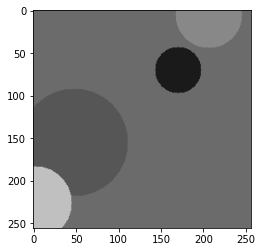

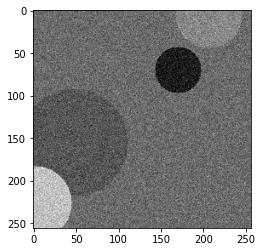

In [4]:
# Data
import numpy as np
import random
import matplotlib.pyplot as plt

def createCircle(width=256, height=256, rad=32):
    w = random.randint(1, height)
    h = random.randint(1, height)
    center = [int(w), int(h)]
    radius = rad
    Y, X = np.ogrid[:height, :width]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def addCircle(test_image, fill=255, rad=32):
    m = createCircle(width=256, height=256 , rad=rad)
    masked_img = test_image.copy()
    masked_img[m] = fill
    return masked_img

def add_noise(img):
    gaussian_noise = np.random.normal(0, 20, img.shape)
    return img + gaussian_noise

img = np.ones([256, 256], dtype=np.uint8) * random.randint(0, 255)
for i in range(4):
    img = addCircle(test_image=img, fill=random.randint(0, 255), rad=random.randint(8, 64))
img_noisy = add_noise(img)

plt.imshow(np.abs(img), cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()
plt.imshow(np.abs(img_noisy), cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

In [5]:
#feed forward
import torch
input = torch.from_numpy(img_noisy)
input = input.unsqueeze(0).unsqueeze(0)
input = input.float()
output = model(input)
signal, noise = output

In [6]:
# Calculate Loss
loss_values = []
total_loss = 0.0

zipped = zip(criterion.items(), [1, 1, 1, 1])
for (k, l), c in zipped:
    if k == "L2":
        loss = float(c) * l(signal+noise, input)
    elif k == 'AR':
        loss = float(c) * l(noise)
    elif k == 'ST':
        loss = float(c) * l(noise)
    elif k == 'GR':
        loss = float(c) * l(signal, signal)
    elif k == 'DF':
        loss = float(c) * l(signal, input)
    elif k == 'LO':
        # loss = float(c) * l(signal, noisy)
        loss = float(c) * l(signal)
    elif k == 'TV':
        loss = float(c) * l(signal)
    total_loss += loss
    loss_values.append(loss.item())

/Users/saeedizadi/Devs/venv/lib/python3.7/site-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
